In [1]:
# installing libraries
!pip install numpy pandas matplotlib pandas-datareader
!pip install mplfinance
!pip install tensorflow scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.2 MB/s eta 0:00:00


In [2]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yfin
import datetime as dt

# scale financial data between as 0 and 1, neural network can work better
from sklearn.preprocessing import MinMaxScaler
# important for sequential data
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

In [3]:
# google ticket symbols
crypto_currency = 'BTC'
against_currency = 'USD'

start = dt.datetime(2016,1,1)
end = dt.datetime.now()

# old code
# data = web.DataReader(f'{crypto_currency}-{against_currency}', 'yahoo', start, end)
# data = pdr.DataReader('BTC','yahoo',start,end)

# new code
yfin.pdr_override()
data = pdr.get_data_yahoo(f'{crypto_currency}-{against_currency}', start, end)
print(data.tail())

[*********************100%%**********************]  1 of 1 completed
                    Open          High           Low         Close  \
Date                                                                 
2023-12-12  41238.734375  42048.304688  40667.562500  41450.222656   
2023-12-13  41468.464844  43429.781250  40676.867188  42890.742188   
2023-12-14  42884.261719  43390.859375  41767.089844  43023.972656   
2023-12-15  43028.250000  43087.824219  41692.968750  41929.757812   
2023-12-16  41937.742188  42337.355469  41723.113281  42195.109375   

               Adj Close       Volume  
Date                                   
2023-12-12  41450.222656  24779520132  
2023-12-13  42890.742188  26797884674  
2023-12-14  43023.972656  25578530178  
2023-12-15  41929.757812  19639442462  
2023-12-16  42195.109375  18823725056  


In [7]:
# preparing data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

prediction_days = 60
x_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)):
  x_train.append(scaled_data[x-prediction_days:x, 0])
  y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [12]:
# create neural network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
# model.Dense(units=1)
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
89/89 [==============================] - 9s 16ms/step - loss: 0.0087
Epoch 2/25
89/89 [==============================] - 1s 12ms/step - loss: 0.0026
Epoch 3/25
89/89 [==============================] - 1s 12ms/step - loss: 0.0024
Epoch 4/25
89/89 [==============================] - 1s 14ms/step - loss: 0.0020
Epoch 5/25
89/89 [==============================] - 1s 13ms/step - loss: 0.0019
Epoch 6/25
89/89 [==============================] - 1s 12ms/step - loss: 0.0017
Epoch 7/25
89/89 [==============================] - 1s 12ms/step - loss: 0.0017
Epoch 8/25
89/89 [==============================] - 1s 12ms/step - loss: 0.0017
Epoch 9/25
89/89 [==============================] - 1s 13ms/step - loss: 0.0015
Epoch 10/25
89/89 [==============================] - 1s 12ms/step - loss: 0.0016
Epoch 11/25
89/89 [==============================] - 1s 17ms/step - loss: 0.0017
Epoch 12/25
89/89 [==============================] - 1s 14ms/step - loss: 0.0013
Epoch 13/25
89/89 [==================

In [13]:
# testing the model
test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

test_data = pdr.get_data_yahoo(f'{crypto_currency}-{against_currency}', test_start, test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.fit_transform(model_inputs)

x_test = []

for x in range(prediction_days, len(model_inputs)):
  x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)

[*********************100%%**********************]  1 of 1 completed
46/46 [==============================] - 1s 7ms/step


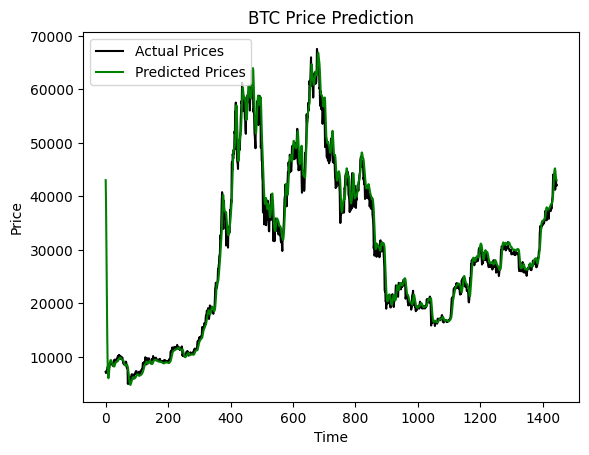

In [17]:
# plotting
plt.plot(actual_prices, color='black', label='Actual Prices')
plt.plot(prediction_prices, color='green', label='Predicted Prices')
plt.title(f"{crypto_currency} Price Prediction")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

In [20]:
# Predict Next Day
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs) + 1, 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(prediction)

1/1 [==============================] - 0s 22ms/step
[[43023.54]]
